In [1]:
# Install torch https://pytorch.org/get-started/locally/

%pip install numpy kagglehub matplotlib opencv-python --quiet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


*Import libraries*

In [36]:
import os
import csv
import cv2
import kagglehub
import numpy as np

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from torch.utils.data import Dataset as BaseDataset

# Semantic Segmentation of Underwater Imagery

Dataset: https://www.kaggle.com/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim

In [37]:
path = kagglehub.dataset_download("ashish2001/semantic-segmentation-of-underwater-imagery-suim")
print("Path to dataset files:", path)

Path to dataset files: /home/mike/.cache/kagglehub/datasets/ashish2001/semantic-segmentation-of-underwater-imagery-suim/versions/2


## 1. Exploration of the dataset

### Underwater Image Segmentation Dataset

This dataset contains over 1500 images with pixel annotations for eight object categories:

- Fish (vertebrates)
- Reefs (invertebrates)
- Aquatic plants
- Wrecks/ruins
- Human divers
- Robots
- Sea-floor

It also includes a test set of 110 images. All images have variable resolutions, though sizes such as **320x240** or **320x256** can be used for benchmarking purposes. 

### Benchmark Dataset
This dataset serves as a benchmark for underwater image segmentation. Segmentation models are heavily domain-dependent, and normal methods may not adapt well to the variety of objects underwater.

### Object Categories and RGB Codes
| Object Category                   | Symbol | RGB Code   |
|-----------------------------------|--------|------------|
| **Background (waterbody)**        | BW     | 000 (black) |
| **Human divers**                  | HD     | 001 (blue)  |
| **Aquatic plants and sea-grass**  | PF     | 010 (green) |
| **Wrecks and ruins**              | WR     | 011 (sky)   |
| **Robots (AUVs/ROVs/instruments)**| RO     | 100 (red)   |
| **Reefs and invertebrates**       | RI     | 101 (pink)  |
| **Fish and vertebrates**          | FV     | 110 (yellow)|
| **Sea-floor and rocks**           | SR     | 111 (white) |

### Folder Structure
The dataset is structured into two main directories: **train_val/** and **TEST/**.

#### `train_val/`
Contains 1525 paired samples for training and validation:

- `images/`: RGB images of underwater scenes.
- `masks/`: Segmentation labels.
  - Each RGB color represents a different object category.

#### `TEST/`
Contains 110 paired samples for benchmark evaluation:

- `images/`: RGB test images.
- `masks/`: Ground truth labels.
  - Combined RGB masks are provided.
  - Individual binary masks are also provided in separate folders.

### Applications of a Trained Model

A segmentation model trained on a dataset like this can be applied to various underwater scenarios, including:

- **Marine Ecology Research**: Monitoring and classifying underwater biodiversity, such as tracking fish populations and studying coral reefs.
- **Marine Archaeology**: Identifying and documenting underwater ruins and wrecks for historical research.
- **Autonomous Underwater Vehicles (AUVs)**: Enhancing navigation and object detection for robots in underwater environments.
- **Environmental Monitoring**: Observing and assessing changes in aquatic vegetation and sea-floor conditions.
- **Search and Rescue Operations**: Locating human divers or equipment during underwater missions.
- **Underwater Exploration**: Mapping and surveying unknown regions of the ocean.
- **Pollution Detection**: Identifying and tracking underwater debris and its impact on ecosystems.

## 2. Data Visualization

The underwater image segmentation dataset includes images of aquatic environments paired with corresponding segmentation masks for eight distinct object categories.

- **Categories**: Background (waterbody), Human divers, Aquatic plants and sea-grass, Wrecks and ruins, Robots, Reefs and invertebrates, Fish and vertebrates, and Sea-floor and rocks.
- **Structure**: Each mask is annotated at the pixel level, where each pixel's RGB value corresponds to a specific object category.

### Data preprocessing

In [38]:
# Mapping categories in TEST/masks
category_colors = {
    "Saliency": [0, 0, 0],  # Background (waterbody) (Called also BW)
    "HD": [0, 0, 255],      # Human divers
    "PF": [0, 255, 0],      # Aquatic plants and sea-grass
    "WR": [0, 255, 255],    # Wrecks and ruins
    "RO": [255, 0, 0],      # Robots (AUVs/ROVs/instruments)
    "RI": [255, 0, 255],    # Reefs and invertebrates
    "FV": [255, 255, 0],    # Fish and vertebrates
    "SR": [255, 255, 255],  # Sea-floor and rocks
}

CLASSES = list(category_colors.keys())
color_to_class = {tuple(value): idx for idx, (_, value) in enumerate(category_colors.items())}
idx_to_class = {idx: class_name for idx, class_name in enumerate(CLASSES)}

In [39]:
def convert_rgb_to_class(mask, color_to_class):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.int64)
    
    for color, class_idx in color_to_class.items():
        color = np.array(color, dtype=np.uint8)
        matches = np.all(mask == color, axis=-1)  # Find pixels matching this color
        class_mask[matches] = class_idx
    
    return class_mask

### Custom Dataset class

The dataset organizes image and mask pairs, with separate logic for handling training/validation and testing data.

When initializing the dataset, the class takes in several parameters: the dataset's `base_path`, whether it's for `train` or test, and optional `augmentation` and `preprocessing` functions. Depending on whether you're training/validating or testing, the class sets the image and mask directories appropriately. 

For the test dataset, the masks might be organized within subfolders representing classes, while training/validation masks are assumed to reside flat within a single directory.

In the `__getitem__` method, the class reads an image using OpenCV, converts it to RGB format, and loads the corresponding mask. The mask is transformed into a class-index format and subsequently converted into a one-hot encoded array. Augmentation and preprocessing steps are applied if provided.

If it is the testing dataset, the class offers an additional method, `get_mask_by_class`, which retrieves a mask corresponding to a specific class by accessing the subfolder structure. This method enables focused evaluation for individual classes.

In [40]:
class CustomDataset(BaseDataset):
    def __init__(self, base_path, train=True, augmentation=None, preprocessing=None):        
        self.base_path = base_path
        self.train = train
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        if train:
            # Training/validation data
            self.images_dir = os.path.join(base_path, "train_val", "images")
            self.masks_dir = os.path.join(base_path, "train_val", "masks")
        else:
            # Test data
            self.images_dir = os.path.join(base_path, "TEST", "images")
            self.masks_dir = os.path.join(base_path, "TEST", "masks")
        
        self.image_files = os.listdir(self.images_dir)
        self.class_values = [key for key,_ in enumerate(CLASSES)]

        # Get all the mask files from the main masks folder and its subdirectories (for test set)
        if train:
            self.mask_files = os.listdir(self.masks_dir)
            self.subfolders = None
        else:
            self.mask_files = [
                filename for filename in os.listdir(self.masks_dir)
                if os.path.isfile(os.path.join(self.masks_dir, filename))
            ]
            self.subfolders = [
                filename for filename in os.listdir(self.masks_dir)
                if os.path.isdir(os.path.join(self.masks_dir, filename))
            ]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image with cv2
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        mask_name = self.image_files[idx].split(".")[0]+".bmp"

        # Prepare mask
        mask_path = os.path.join(self.masks_dir, mask_name)
        rgb_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        rgb_mask = cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Convert RGB mask to class index mask
        mask = convert_rgb_to_class(rgb_mask, color_to_class)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
                       
        return image, mask
    
    def get_mask_by_class(self, item_idx, class_idx):
        if self.train == True:
            return None
        else:
            class_name = idx_to_class[class_idx]
            mask_name = self.image_files[item_idx].split(".")[0]+".bmp"
            mask_path = os.path.join(self.masks_dir, class_name, mask_name)
            rgb_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            rgb_mask = cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB) 
            return rgb_mask

In [41]:
train_dataset = CustomDataset(base_path=path, train=True)
test_dataset = CustomDataset(base_path=path, train=False)

In [42]:
def visualize(image, mask, alpha=0.5):
    """
    Visualize the original image and the original image with the segmentation mask overlaid.
    
    Parameters:
    - image: Original image (H, W, 3).
    - mask: Segmentation mask, either multi-class (H, W, num_classes) or RGB (H, W, 3).
    - alpha: Transparency level for the mask overlay.
    """
    # Normalize the image if necessary
    if image.max() > 1:
        image = image / 255.0

    # Determine if the mask is multi-class or RGB
    if mask.ndim == 3 and mask.shape[-1] > 3:  # Multi-class segmentation
        # Define a color map with unique colors for each class
        colors = plt.get_cmap('tab20', mask.shape[2])
        cmap = ListedColormap([colors(i) for i in range(mask.shape[2])])

        # Get the class with the highest score at each pixel
        combined_mask = np.argmax(mask, axis=2)

        # Create a color image of the mask for overlay
        color_mask = cmap(combined_mask / combined_mask.max())[:, :, :3]  # Remove alpha channel if present
    elif mask.ndim == 3 and mask.shape[-1] == 3:  # RGB image mask
        # Normalize RGB mask if necessary
        if mask.max() > 1:
            mask = mask / 255.0
        color_mask = mask
    else:
        raise ValueError("Mask must have shape (H, W, num_classes) or (H, W, 3).")

    # Ensure the image has the shape (height, width, channels)
    if image.shape[0] == 3:  # If shape is (3, height, width)
        image = np.transpose(image, (1, 2, 0))  # Transpose to (height, width, 3)

    # Overlay the mask on the original image
    overlayed_image = (1 - alpha) * image + alpha * color_mask

    # Clip values to ensure they stay within [0, 1]
    overlayed_image = np.clip(overlayed_image, 0, 1)

    # Plot original and overlayed images side by side
    plt.figure(figsize=(12, 6))

    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Show the image with segmentation overlay
    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title("Image with Segmentation Overlay")
    plt.axis('off')

    plt.show()

### Images examples with mask overlay from dataset

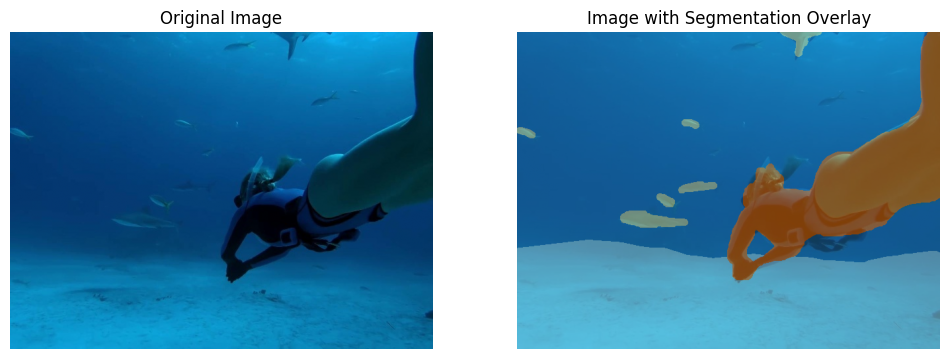

In [43]:
image, mask = train_dataset[13]
visualize(image, mask)

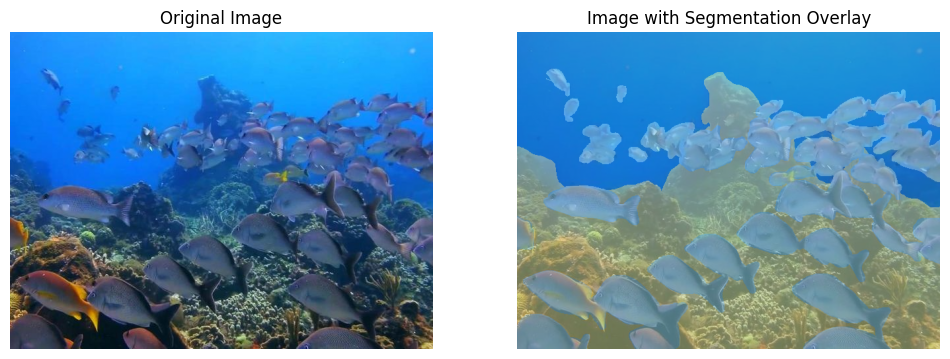

In [44]:
image, mask = test_dataset[89]
visualize(image, mask)

### Getting insights of the dataset

In [45]:
figsize=(12, 6)

def check_and_display_image(image_path):
  if os.path.exists(image_path) and os.path.isfile(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return True
  return False

def create_folder_if_not_exist(folder):
  if not os.path.exists(folder):
      os.makedirs(folder)
      
def write_csv(filename, headers, values, multi_rows=False):
  with open(f"{filename}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        if multi_rows == True:
          for v in values:
            writer.writerow(v)
        else:
          writer.writerow(values)
      
folder = "results/database"
create_folder_if_not_exist(folder)

In [46]:
def category_distribution(dataset):
    filename = f"{folder}/masks_counts_per_class"    
    if check_and_display_image(f"{filename}.png"):
        return
    
    class_counts = {cls: 0 for cls in CLASSES}

    for _, img in dataset:
        for channel_idx in range(img.shape[-1]):  # img.shape[-1] gives the last dimension size, 8 in this case
            mask = img[..., channel_idx]
            if np.any(mask):
                class_counts[idx_to_class[channel_idx]] += 1

    # Plot the counts
    fig = plt.figure(figsize=figsize, facecolor='lightgray')
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightgray')
    plt.bar(class_counts.keys(), class_counts.values(), 
            color=[np.array(color) / 255 for color in category_colors.values()])
    plt.title("Counts Per Class")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha="right")
    plt.savefig(f"{filename}.png")
    plt.tight_layout()
    plt.show()
    
    write_csv(filename, class_counts.keys(), class_counts.values())

def pixel_intensity_distribution(dataset, downsample_factor=None):
    filename = f"{folder}/images_pixel_intensity_distribution"    
    if check_and_display_image(f"{filename}.png"):
        return
    
    # Accumulator for pixel intensity histogram (256 bins for gray-scale images)
    intensity_histogram = np.zeros(256, dtype=int)

    for img, _ in dataset:
        # Optional downsampling to reduce image resolution
        if downsample_factor:
            img = cv2.resize(img, (img.shape[1] // downsample_factor, img.shape[0] // downsample_factor))

        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Increment histogram bin counts
        intensity_histogram += np.bincount(gray_img.flatten(), minlength=256)

    plt.figure(figsize=figsize)
    plt.bar(range(256), intensity_histogram, color='gray', alpha=0.7, edgecolor='black')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution')
    plt.savefig(f"{filename}.png")
    plt.show()

    write_csv(filename, ["Pixel Intensity", "Frequency"], enumerate(intensity_histogram), multi_rows=True)
    
def pixel_distribution_per_image_and_class(dataset):
    total_counts_filename = f"{folder}/mask_pixel_counts_per_class"
    if check_and_display_image(f"{total_counts_filename}.png"):
        return
    
    filename = f"{folder}/masks_pixel_counts_per_image_and_class"
    total_pixel_counts = {cls: 0 for cls in CLASSES}

    with open(f"{filename}.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        
        header = ["Image_Index"] + CLASSES
        writer.writerow(header)

        for idx, (_, img) in enumerate(dataset):
            pixel_counts = {cls: 0 for cls in CLASSES}

            for channel_idx in range(img.shape[-1]):  # Iterate over the 8 classes
                mask = img[..., channel_idx]
                pixel_counts[idx_to_class[channel_idx]] += np.count_nonzero(mask)  # Count non-zero pixels in this mask

            for class_name in pixel_counts:
                total_pixel_counts[class_name] += pixel_counts[class_name]

            writer.writerow([f"Image_{idx}"] + list(pixel_counts.values()))
    
    fig = plt.figure(figsize=figsize, facecolor='lightgray')
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightgray')
    plt.bar(total_pixel_counts.keys(), total_pixel_counts.values(), 
            color=[np.array(color) / 255 for color in category_colors.values()])
    plt.title("Counts Per Class")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha="right")
    plt.savefig(f"{total_counts_filename}.png")
    plt.tight_layout()
    plt.show()
    
    write_csv(total_counts_filename, total_pixel_counts.keys(), total_pixel_counts.values())


Analyzing pixel intensity distribution in images...


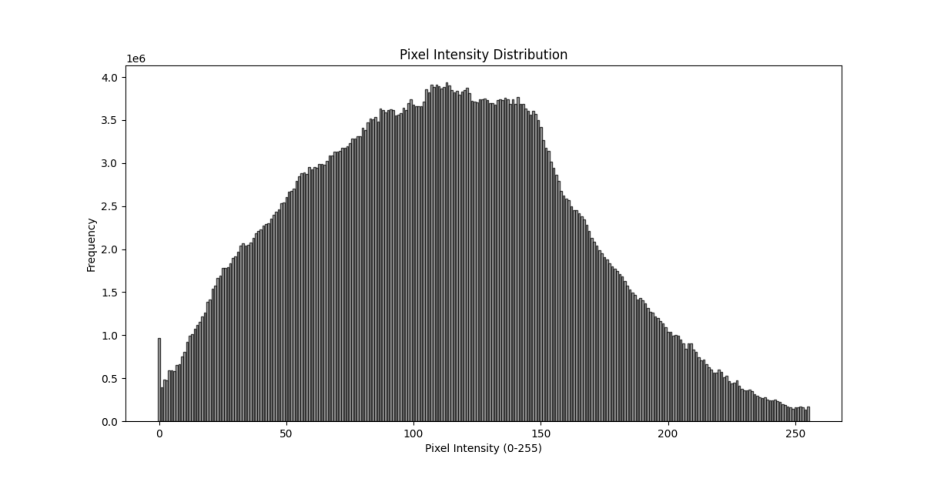

In [47]:
print("Analyzing pixel intensity distribution in images...")
pixel_intensity_distribution(train_dataset)

Analyzing classes count in masks...


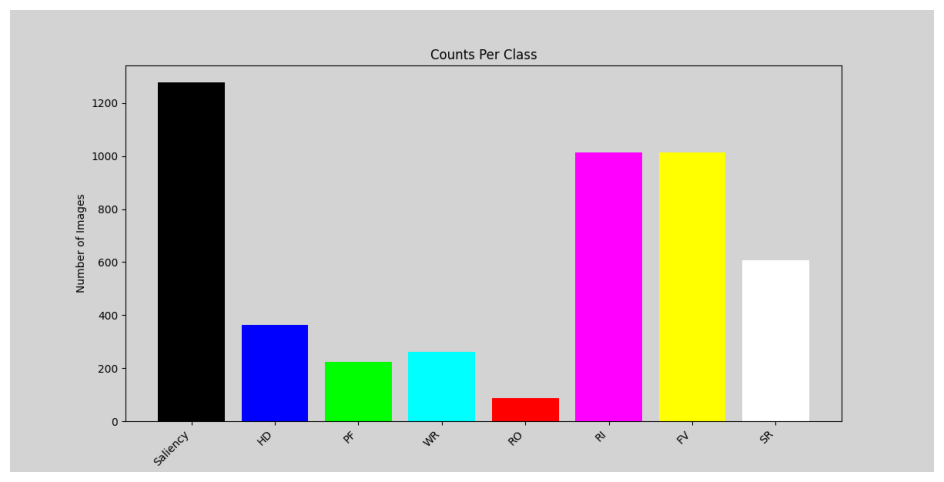

In [48]:
print("Analyzing classes count in masks...")
category_distribution(train_dataset)

Analyzing pixel distribution per image classes in masks...


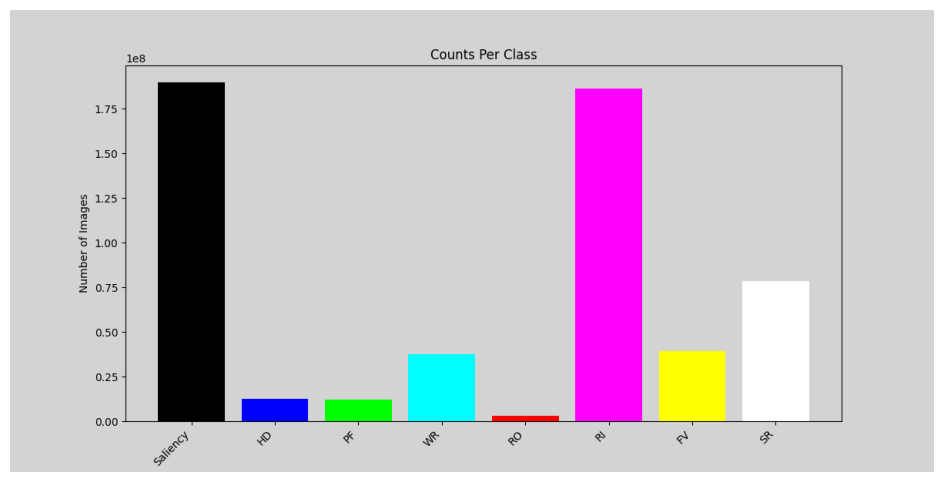

In [49]:
print("Analyzing pixel distribution per image classes in masks...")
pixel_distribution_per_image_and_class(train_dataset)

We can see from the chart that the classes are highly unbalanced